In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
rnnamp_model = pd.read_csv('/kaggle/input/hemolytic/combined.csv')

In [4]:
X=rnnamp_model['text']
y=np.array(rnnamp_model['labels'])


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from keras.saving import register_keras_serializable


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=0)


In [7]:
'''
# Example data
texts = X_train

# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(texts)
test_seq=tokenizer.texts_to_sequences(X_test)
# Pad sequences to a fixed length
maxlen = 100  # Adjust as needed based on your data
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
test=pad_sequences(test_seq, maxlen=maxlen, padding='post', truncating='post')
# Convert to NumPy array
X_train = tf.constant(padded_sequences)
X_test = tf.constant(test)
'''

"\n# Example data\ntexts = X_train\n\n# Tokenize the texts\ntokenizer = Tokenizer()\ntokenizer.fit_on_texts(texts)\n\n# Convert text to sequences of integers\nsequences = tokenizer.texts_to_sequences(texts)\ntest_seq=tokenizer.texts_to_sequences(X_test)\n# Pad sequences to a fixed length\nmaxlen = 100  # Adjust as needed based on your data\npadded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')\ntest=pad_sequences(test_seq, maxlen=maxlen, padding='post', truncating='post')\n# Convert to NumPy array\nX_train = tf.constant(padded_sequences)\nX_test = tf.constant(test)\n"

In [8]:
X_train=np.array(X_train)
X_test=np.array(X_test)

In [9]:
def tokenizer(text,max_len):
  #dic={'A':1,'G':1,'V':1,'I':2,'L':2,'F':2,'P':2,'Y':3,'M':3,'T':3,'S':3,'H':4,'N':4,'Q':4,'W':4,'K':5,'R':5,'D':6,'E':6,'C':7}
  dic={'A':1,'G':2,'V':3,'I':4,'L':5,'F':6,'P':7,'Y':8,'M':9,'T':10,'S':11,'H':12,'N':13,'Q':14,'W':15,'K':16,'R':17,'D':18,'E':19,'C':20}
  onehot=[]
  t=[]
  for i in range(len(text)):
    row=[]
    l=[]
    char=text[i].split(' ')
    for j in range(max_len):
      if j< len(char):
        row.append(dic[char[j]])
        r=np.zeros(20)
        r[dic[char[j]]-1]=1
      else:
        r=np.ones(20)*-1
        row.append(0)
      l.append(r)
    l=np.array(l)
    onehot.append(l)
    t.append(row)
  onehot=np.array(onehot)
  t=np.array(t)
  return t,onehot
max_len=50
X_train,onehot_train=tokenizer(X_train,max_len)
X_test,onehot_test=tokenizer(X_test,max_len)


In [10]:
def positional_encoding(positions, d):

    # initialize a matrix angle_rads of all the angles
    pos=np.arange(positions)[:, np.newaxis] #Column vector containing the position span [0,1,..., positions]
    k= np.arange(d)[np.newaxis, :]  #Row vector containing the dimension span [[0, 1, ..., d-1]]
    i = k//2
    angle_rads = pos/(10000**(2*i/d)) #Matrix of angles indexed by (pos,i)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    #adds batch axis
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


In [11]:
# Define the Transformer model
@register_keras_serializable()
class TransformerModel(keras.Model):
    def __init__(self, input_vocab_size, d_model, num_heads, ff_dim, rate=0.1, maxlen=50):
        super(TransformerModel, self).__init__()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.PE = positional_encoding(maxlen, d_model)
        self.transformer_block = TransformerBlock_Encode(d_model, num_heads, ff_dim, rate)
        self.transformer_block2 = TransformerBlock_decode(d_model, num_heads, ff_dim, rate)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(512, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2=0.001))
        self.fc3 = layers.Dense(256, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2=0.01))
        self.fc2 = layers.Dense(1, activation="sigmoid",kernel_regularizer=tf.keras.regularizers.l2(l2=0.1))

    def call(self, inputs, training):
        x = self.embedding(inputs)
        #x = x+self.PE
        y = self.transformer_block(x)
        y = self.dropout1(y)
        x = self.transformer_block2(x,y,y)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        return self.fc2(x)
class TransformerBlock_decode(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock_decode, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(d_model)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-1)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-1)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-1)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
    def call(self, inputs,q,k, training):
        attn_output = self.att(inputs, inputs,inputs)
        out1 = self.layernorm1(inputs + attn_output)
        attn_output1=self.att(q, k,out1)
        out2 = self.layernorm1(out1 + attn_output1)
        ffn_output = self.ffn(out2)
        return self.layernorm2(out2 + ffn_output)

# Define the TransformerBlock layer
class TransformerBlock_Encode(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock_Encode, self).__init__()
        self.con= layers.Conv1D(256,5,padding='same')
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(d_model)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-1)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-1)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    def call(self, inputs, training):
        inputs=self.con(inputs)
        attn_output = self.att(inputs, inputs,inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)



# Define your data loading and preprocessing here
# Example: X_train, y_train = load_data_and_preprocess()

# Define the model
input_vocab_size = 1024  # Replace with the actual vocabulary size
d_model = 256
num_heads = 2
ff_dim = 256

model = TransformerModel(input_vocab_size, d_model, num_heads, ff_dim)
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
# Compile the model
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["accuracy"])

callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),tf.keras.callbacks.ModelCheckpoint(filepath='AMAP1.h5', monitor='val_accuracy', save_best_only=True,mode='auto',save_weights_only=True)]

# Train the model
history = model.fit(X_train,y_train,epochs = 100,batch_size=32,validation_split=0.1,callbacks=[callback],verbose=1,shuffle= True)



Epoch 1/100
162/162 [==============================] - 15s 24ms/step - loss: 4.4724 - accuracy: 0.7835 - val_loss: 3.8531 - val_accuracy: 0.8539
Epoch 2/100
162/162 [==============================] - 3s 17ms/step - loss: 3.3819 - accuracy: 0.8620 - val_loss: 3.0105 - val_accuracy: 0.8696
Epoch 3/100
162/162 [==============================] - 3s 17ms/step - loss: 2.6383 - accuracy: 0.8876 - val_loss: 2.4225 - val_accuracy: 0.8574
Epoch 4/100
162/162 [==============================] - 3s 18ms/step - loss: 2.0971 - accuracy: 0.9091 - val_loss: 1.9834 - val_accuracy: 0.8765
Epoch 5/100
162/162 [==============================] - 3s 18ms/step - loss: 1.7016 - accuracy: 0.9255 - val_loss: 1.6825 - val_accuracy: 0.8835
Epoch 6/100
162/162 [==============================] - 3s 17ms/step - loss: 1.4214 - accuracy: 0.9303 - val_loss: 1.4468 - val_accuracy: 0.8800
Epoch 7/100
162/162 [==============================] - 3s 18ms/step - loss: 1.2048 - accuracy: 0.9404 - val_loss: 1.2580 - val_accuracy

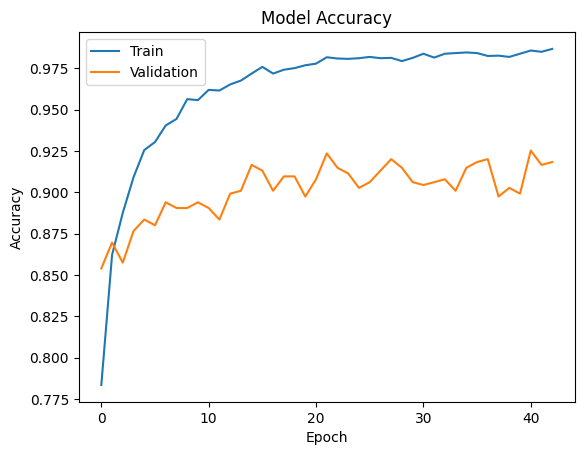

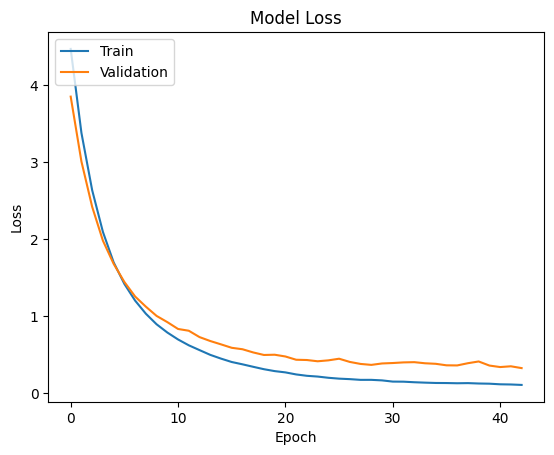

In [12]:
# Plot training accuracy
plt.plot(history.history['accuracy'][:-10])
plt.plot(history.history['val_accuracy'][:-10])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training loss
plt.plot(history.history['loss'][:-10])
plt.plot(history.history['val_loss'][:-10])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
model.summary()

Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 embedding (Embedding)       multiple                  262144    
                                                                 
 transformer_block__encode   multiple                  986624    
 (TransformerBlock_Encode)                                       
                                                                 
 transformer_block_decode (  multiple                  658688    
 TransformerBlock_decode)                        

In [14]:
model.load_weights('AMAP1.h5')

In [15]:
model1=model

In [16]:
from sklearn import model_selection, metrics
y_pred=model.predict(X_train)
y_pred[y_pred>0.5]=1
y_pred[y_pred<0.5]=0

cv_preds = y_pred
print('combined train datasets')
name='deep learning'
print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_train, cv_preds)))
print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_train, cv_preds)))
print("%s: Matthews Coefficient %0.2f%%" % (name, 100*metrics.matthews_corrcoef(y_train, cv_preds)))
print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_train, cv_preds)))
print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_train, cv_preds)))
target_names = ['low 0', 'high 1']
print(metrics.classification_report(y_train, cv_preds, target_names=target_names))

# Predictions Validation Set
print('combined test datasets')
y_pred2=model.predict(X_test)
l=np.zeros(len(y_pred2))
l=l.reshape(-1,1)
l[y_pred2>=0.5]=1
l[y_pred2<0.5]=0
cv_preds2 = l
print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_test, cv_preds2)))
print("%s: Precision %0.2f%%" % (name, 100*metrics.precision_score(y_test, cv_preds2)))
print("%s: Recall %0.2f%%" % (name, 100*metrics.recall_score(y_test, cv_preds2)))
print("%s: Matthews Coefficient %0.2f%%" % (name, 100*metrics.matthews_corrcoef(y_test, cv_preds2)))
print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_test, cv_preds2)))
print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_test, cv_preds2)))
target_names = ['low 0', 'high 1']
print(metrics.classification_report(y_test, cv_preds2, target_names=target_names))

180/180 [==============================] - 2s 7ms/step
combined train datasets
deep learning: Accuracy 98.40%
deep learning: Precision-Recall 97.04%
deep learning: Matthews Coefficient 96.71%
deep learning: Cohen Kappa Score 96.71%
deep learning: ROC AUC Score 98.35%
              precision    recall  f1-score   support

       low 0       0.99      0.99      0.99      3332
      high 1       0.98      0.98      0.98      2411

    accuracy                           0.98      5743
   macro avg       0.98      0.98      0.98      5743
weighted avg       0.98      0.98      0.98      5743

combined test datasets
45/45 [==============================] - 0s 8ms/step
deep learning: Accuracy 89.21%
deep learning: Precision 87.44%
deep learning: Recall 86.41%
deep learning: Matthews Coefficient 77.74%
deep learning: Cohen Kappa Score 77.73%
deep learning: ROC AUC Score 88.80%
              precision    recall  f1-score   support

       low 0       0.90      0.91      0.91       840
      hig

In [17]:
rnnamp_model = pd.read_csv('/kaggle/input/hemolytic/hlppredfuse.csv')

In [18]:
X=rnnamp_model['text']
y=np.array(rnnamp_model['labels'])


In [19]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=0)


In [20]:
X_train=np.array(X_train)
X_test=np.array(X_test)

In [21]:
def tokenizer(text,max_len):
  #dic={'A':1,'G':1,'V':1,'I':2,'L':2,'F':2,'P':2,'Y':3,'M':3,'T':3,'S':3,'H':4,'N':4,'Q':4,'W':4,'K':5,'R':5,'D':6,'E':6,'C':7}
  dic={'A':1,'G':2,'V':3,'I':4,'L':5,'F':6,'P':7,'Y':8,'M':9,'T':10,'S':11,'H':12,'N':13,'Q':14,'W':15,'K':16,'R':17,'D':18,'E':19,'C':20}
  onehot=[]
  t=[]
  for i in range(len(text)):
    row=[]
    l=[]
    char=text[i].split(' ')
    for j in range(max_len):
      if j< len(char):
        row.append(dic[char[j]])
        r=np.zeros(20)
        r[dic[char[j]]-1]=1
      else:
        r=np.ones(20)*-1
        row.append(0)
      l.append(r)
    l=np.array(l)
    onehot.append(l)
    t.append(row)
  onehot=np.array(onehot)
  t=np.array(t)
  return t,onehot
max_len=50
X_train,onehot_train=tokenizer(X_train,max_len)
X_test,onehot_test=tokenizer(X_test,max_len)


In [22]:
# Define the Transformer model
@register_keras_serializable()
class TransformerModel(keras.Model):
    def __init__(self, input_vocab_size, d_model, num_heads, ff_dim, rate=0.1, maxlen=50):
        super(TransformerModel, self).__init__()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.PE = positional_encoding(maxlen, d_model)
        self.transformer_block = TransformerBlock_Encode(d_model, num_heads, ff_dim, rate)
        self.transformer_block2 = TransformerBlock_decode(d_model, num_heads, ff_dim, rate)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(512, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2=0.001))
        self.fc3 = layers.Dense(256, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2=0.01))
        self.fc2 = layers.Dense(1, activation="sigmoid",kernel_regularizer=tf.keras.regularizers.l2(l2=0.1))

    def call(self, inputs, training):
        x = self.embedding(inputs)
        #x = x+self.PE
        y = self.transformer_block(x)
        y = self.dropout1(y)
        x = self.transformer_block2(x,y,y)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        return self.fc2(x)
class TransformerBlock_decode(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock_decode, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(d_model)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-1)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-1)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-1)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
    def call(self, inputs,q,k, training):
        attn_output = self.att(inputs, inputs,inputs)
        out1 = self.layernorm1(inputs + attn_output)
        attn_output1=self.att(q, k,out1)
        out2 = self.layernorm1(out1 + attn_output1)
        ffn_output = self.ffn(out2)
        return self.layernorm2(out2 + ffn_output)

# Define the TransformerBlock layer
class TransformerBlock_Encode(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock_Encode, self).__init__()
        self.con= layers.Conv1D(256,5,padding='same')
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(d_model)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-1)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-1)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    def call(self, inputs, training):
        inputs=self.con(inputs)
        attn_output = self.att(inputs, inputs,inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)


# Define your data loading and preprocessing here
# Example: X_train, y_train = load_data_and_preprocess()

# Define the model
input_vocab_size = 1024  # Replace with the actual vocabulary size
d_model = 256
num_heads = 2
ff_dim = 256
model2 = TransformerModel(input_vocab_size, d_model, num_heads, ff_dim)
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
# Compile the model
model2.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["accuracy"])

callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),tf.keras.callbacks.ModelCheckpoint(filepath='AMAP2.h5', monitor='val_accuracy', save_best_only=True,mode='auto',save_weights_only=True)]

# Train the model
history = model2.fit(X_train,y_train,epochs = 100,batch_size=32,validation_split=0.1,callbacks=[callback],verbose=1,shuffle= True)


Epoch 1/100
80/80 [==============================] - 11s 33ms/step - loss: 4.6916 - accuracy: 0.8476 - val_loss: 4.1994 - val_accuracy: 0.9255
Epoch 2/100
80/80 [==============================] - 2s 21ms/step - loss: 3.9482 - accuracy: 0.9325 - val_loss: 3.6413 - val_accuracy: 0.9504
Epoch 3/100
80/80 [==============================] - 2s 20ms/step - loss: 3.3808 - accuracy: 0.9593 - val_loss: 3.2301 - val_accuracy: 0.9255
Epoch 4/100
80/80 [==============================] - 1s 18ms/step - loss: 2.9266 - accuracy: 0.9625 - val_loss: 2.7630 - val_accuracy: 0.9433
Epoch 5/100
80/80 [==============================] - 2s 20ms/step - loss: 2.5216 - accuracy: 0.9763 - val_loss: 2.4373 - val_accuracy: 0.9397
Epoch 6/100
80/80 [==============================] - 2s 19ms/step - loss: 2.1995 - accuracy: 0.9767 - val_loss: 2.1434 - val_accuracy: 0.9539
Epoch 7/100
80/80 [==============================] - 1s 18ms/step - loss: 1.9144 - accuracy: 0.9814 - val_loss: 1.9028 - val_accuracy: 0.9397
Epoch

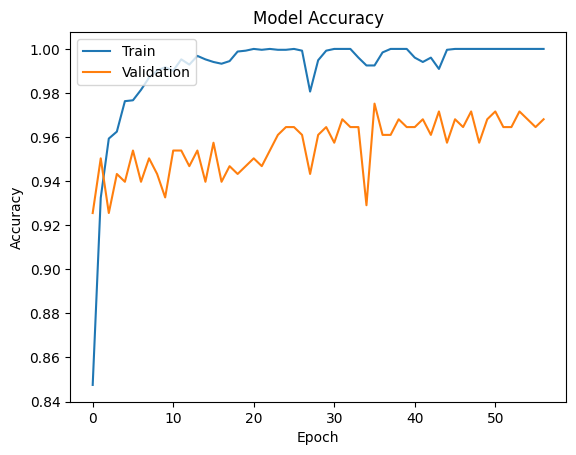

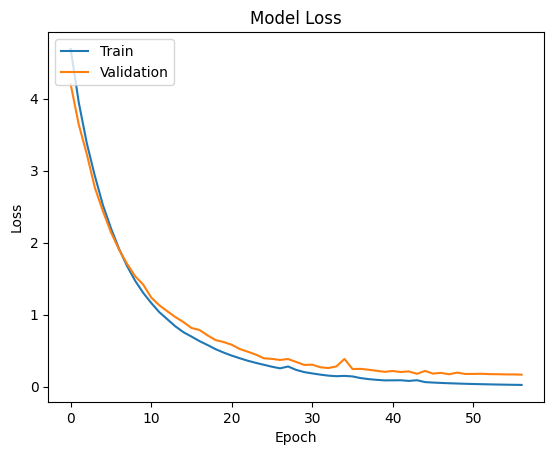

In [23]:
# Plot training accuracy
plt.plot(history.history['accuracy'][:-10])
plt.plot(history.history['val_accuracy'][:-10])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training loss
plt.plot(history.history['loss'][:-10])
plt.plot(history.history['val_loss'][:-10])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
model2.load_weights('AMAP2.h5')

In [25]:
model2.save_weights("AMAP2.h5")

In [26]:
from sklearn import model_selection, metrics
y_pred=model2.predict(X_train)
y_pred[y_pred>0.5]=1
y_pred[y_pred<0.5]=0

cv_preds = y_pred
print('hlppredfuse train datasets')
name='deep learning'
print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_train, cv_preds)))
print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_train, cv_preds)))
print("%s: Matthews Coefficient %0.2f%%" % (name, 100*metrics.matthews_corrcoef(y_train, cv_preds)))
print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_train, cv_preds)))
print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_train, cv_preds)))
target_names = ['low 0', 'high 1']
print(metrics.classification_report(y_train, cv_preds, target_names=target_names))

# Predictions Validation Set
print('hlppredfuse test datasets')
y_pred2=model2.predict(X_test)
l=np.zeros(len(y_pred2))
l=l.reshape(-1,1)
l[y_pred2>=0.5]=1
l[y_pred2<0.5]=0
cv_preds2 = l
print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_test, cv_preds2)))
print("%s: Precision %0.2f%%" % (name, 100*metrics.precision_score(y_test, cv_preds2)))
print("%s: Recall %0.2f%%" % (name, 100*metrics.recall_score(y_test, cv_preds2)))
print("%s: Matthews Coefficient %0.2f%%" % (name, 100*metrics.matthews_corrcoef(y_test, cv_preds2)))
print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_test, cv_preds2)))
print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_test, cv_preds2)))
target_names = ['low 0', 'high 1']
print(metrics.classification_report(y_test, cv_preds2, target_names=target_names))

88/88 [==============================] - 1s 8ms/step
hlppredfuse train datasets
deep learning: Accuracy 99.61%
deep learning: Precision-Recall 98.96%
deep learning: Matthews Coefficient 99.09%
deep learning: Cohen Kappa Score 99.09%
deep learning: ROC AUC Score 99.53%
              precision    recall  f1-score   support

       low 0       1.00      1.00      1.00      1938
      high 1       0.99      0.99      0.99       876

    accuracy                           1.00      2814
   macro avg       1.00      1.00      1.00      2814
weighted avg       1.00      1.00      1.00      2814

hlppredfuse test datasets
22/22 [==============================] - 0s 6ms/step
deep learning: Accuracy 96.45%
deep learning: Precision 93.33%
deep learning: Recall 95.45%
deep learning: Matthews Coefficient 91.80%
deep learning: Cohen Kappa Score 91.79%
deep learning: ROC AUC Score 96.18%
              precision    recall  f1-score   support

       low 0       0.98      0.97      0.97       484
     

In [27]:
rnnamp_model = pd.read_csv('/kaggle/input/hemolytic/rnnamp.csv')

In [28]:
X=rnnamp_model['text']
y=np.array(rnnamp_model['labels'])


In [29]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=0)


In [30]:
X_train=np.array(X_train)
X_test=np.array(X_test)

In [31]:
def tokenizer(text,max_len):
  #dic={'A':1,'G':1,'V':1,'I':2,'L':2,'F':2,'P':2,'Y':3,'M':3,'T':3,'S':3,'H':4,'N':4,'Q':4,'W':4,'K':5,'R':5,'D':6,'E':6,'C':7}
  dic={'A':1,'G':2,'V':3,'I':4,'L':5,'F':6,'P':7,'Y':8,'M':9,'T':10,'S':11,'H':12,'N':13,'Q':14,'W':15,'K':16,'R':17,'D':18,'E':19,'C':20}
  onehot=[]
  t=[]
  for i in range(len(text)):
    row=[]
    l=[]
    char=text[i].split(' ')
    for j in range(max_len):
      if j< len(char):
        row.append(dic[char[j]])
        r=np.zeros(20)
        r[dic[char[j]]-1]=1
      else:
        r=np.ones(20)*-1
        row.append(0)
      l.append(r)
    l=np.array(l)
    onehot.append(l)
    t.append(row)
  onehot=np.array(onehot)
  t=np.array(t)
  return t,onehot
max_len=50
X_train,onehot_train=tokenizer(X_train,max_len)
X_test,onehot_test=tokenizer(X_test,max_len)


In [32]:
# Define the Transformer model
@register_keras_serializable()
class TransformerModel(keras.Model):
    def __init__(self, input_vocab_size, d_model, num_heads, ff_dim, rate=0.1, maxlen=50):
        super(TransformerModel, self).__init__()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.PE = positional_encoding(maxlen, d_model)
        self.transformer_block = TransformerBlock_Encode(d_model, num_heads, ff_dim, rate)
        self.transformer_block2 = TransformerBlock_decode(d_model, num_heads, ff_dim, rate)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(512, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2=0.001))
        self.fc3 = layers.Dense(256, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(l2=0.01))
        self.fc2 = layers.Dense(1, activation="sigmoid",kernel_regularizer=tf.keras.regularizers.l2(l2=0.1))

    def call(self, inputs, training):
        x = self.embedding(inputs)
        #x = x+self.PE
        y = self.transformer_block(x)
        y = self.dropout1(y)
        x = self.transformer_block2(x,y,y)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        return self.fc2(x)
class TransformerBlock_decode(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock_decode, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(d_model)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-1)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-1)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-1)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
    def call(self, inputs,q,k, training):
        attn_output = self.att(inputs, inputs,inputs)
        out1 = self.layernorm1(inputs + attn_output)
        attn_output1=self.att(q, k,out1)
        out2 = self.layernorm1(out1 + attn_output1)
        ffn_output = self.ffn(out2)
        return self.layernorm2(out2 + ffn_output)

# Define the TransformerBlock layer
class TransformerBlock_Encode(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock_Encode, self).__init__()
        self.con= layers.Conv1D(256,5,padding='same')
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(d_model)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-1)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-1)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    def call(self, inputs, training):
        inputs=self.con(inputs)
        attn_output = self.att(inputs, inputs,inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)



# Define your data loading and preprocessing here
# Example: X_train, y_train = load_data_and_preprocess()

# Define the model
input_vocab_size = 1024  # Replace with the actual vocabulary size
d_model = 256
num_heads = 2
ff_dim = 256
model3 = TransformerModel(input_vocab_size, d_model, num_heads, ff_dim)
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
# Compile the model
model3.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=["accuracy"])
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),tf.keras.callbacks.ModelCheckpoint(filepath='AMAP3.h5', monitor='val_accuracy', save_best_only=True,mode='auto',save_weights_only=True)]

# Train the model
history = model3.fit(X_train,y_train,epochs = 100,batch_size=32,validation_split=0.1,callbacks=[callback],verbose=1,shuffle= True)


Epoch 1/100
58/58 [==============================] - 10s 33ms/step - loss: 5.1096 - accuracy: 0.6250 - val_loss: 4.7953 - val_accuracy: 0.6634
Epoch 2/100
58/58 [==============================] - 1s 20ms/step - loss: 4.5455 - accuracy: 0.7462 - val_loss: 4.3870 - val_accuracy: 0.7220
Epoch 3/100
58/58 [==============================] - 1s 18ms/step - loss: 4.1097 - accuracy: 0.7870 - val_loss: 4.1650 - val_accuracy: 0.6634
Epoch 4/100
58/58 [==============================] - 1s 20ms/step - loss: 3.7402 - accuracy: 0.8141 - val_loss: 3.6812 - val_accuracy: 0.7756
Epoch 5/100
58/58 [==============================] - 1s 18ms/step - loss: 3.3945 - accuracy: 0.8375 - val_loss: 3.4438 - val_accuracy: 0.7610
Epoch 6/100
58/58 [==============================] - 1s 18ms/step - loss: 3.0958 - accuracy: 0.8592 - val_loss: 3.1501 - val_accuracy: 0.7610
Epoch 7/100
58/58 [==============================] - 1s 18ms/step - loss: 2.8272 - accuracy: 0.8810 - val_loss: 2.9421 - val_accuracy: 0.7415
Epoch

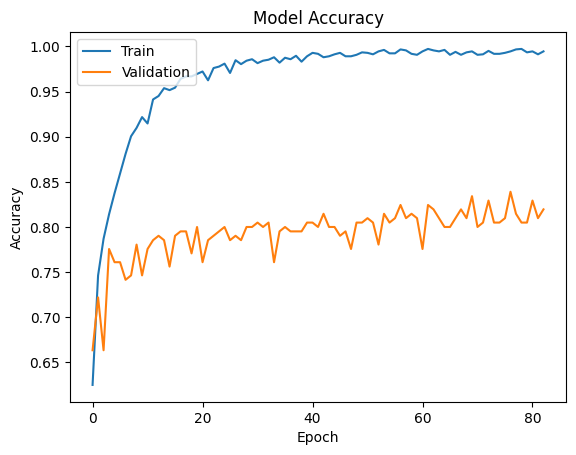

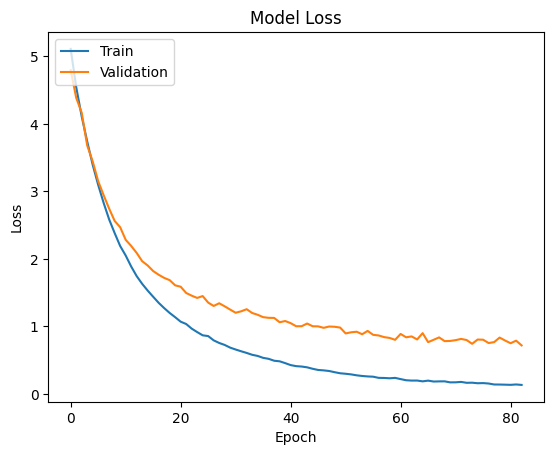

In [33]:
# Plot training accuracy
plt.plot(history.history['accuracy'][:-10])
plt.plot(history.history['val_accuracy'][:-10])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training loss
plt.plot(history.history['loss'][:-10])
plt.plot(history.history['val_loss'][:-10])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
model3.load_weights('AMAP3.h5')

In [35]:
from sklearn import model_selection, metrics
y_pred=model3.predict(X_train)
y_pred[y_pred>0.5]=1
y_pred[y_pred<0.5]=0

cv_preds = y_pred
print('rnnamp train datasets')
name='deep learning'
print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_train, cv_preds)))
print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_train, cv_preds)))
print("%s: Matthews Coefficient %0.2f%%" % (name, 100*metrics.matthews_corrcoef(y_train, cv_preds)))
print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_train, cv_preds)))
print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_train, cv_preds)))
target_names = ['low 0', 'high 1']
print(metrics.classification_report(y_train, cv_preds, target_names=target_names))

# Predictions Validation Set
print('rnnamp test datasets')
y_pred2=model3.predict(X_test)
l=np.zeros(len(y_pred2))
l=l.reshape(-1,1)
l[y_pred2>=0.5]=1
l[y_pred2<0.5]=0
cv_preds2 = l
print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_test, cv_preds2)))
print("%s: Precision %0.2f%%" % (name, 100*metrics.precision_score(y_test, cv_preds2)))
print("%s: Recall %0.2f%%" % (name, 100*metrics.recall_score(y_test, cv_preds2)))
print("%s: Matthews Coefficient %0.2f%%" % (name, 100*metrics.matthews_corrcoef(y_test, cv_preds2)))
print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_test, cv_preds2)))
print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_test, cv_preds2)))
target_names = ['low 0', 'high 1']
print(metrics.classification_report(y_test, cv_preds2, target_names=target_names))

64/64 [==============================] - 1s 9ms/step
rnnamp train datasets
deep learning: Accuracy 98.14%
deep learning: Precision-Recall 97.26%
deep learning: Matthews Coefficient 96.27%
deep learning: Cohen Kappa Score 96.26%
deep learning: ROC AUC Score 98.10%
              precision    recall  f1-score   support

       low 0       0.99      0.97      0.98       952
      high 1       0.98      0.99      0.98      1093

    accuracy                           0.98      2045
   macro avg       0.98      0.98      0.98      2045
weighted avg       0.98      0.98      0.98      2045

rnnamp test datasets
16/16 [==============================] - 0s 7ms/step
deep learning: Accuracy 80.27%
deep learning: Precision 79.36%
deep learning: Recall 83.83%
deep learning: Matthews Coefficient 60.50%
deep learning: Cohen Kappa Score 60.40%
deep learning: ROC AUC Score 80.13%
              precision    recall  f1-score   support

       low 0       0.81      0.76      0.79       246
      high 1   

In [36]:
model3.save_weights("AMAP3.h5")